In [1]:
import math
import time
import threading
import itertools
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = fetch_california_housing() #載入california_housing資料集
X = data.data
y = data.target

N = 100 #Multi‑armed bandits 的輪數


#隨機森林的超參數
list_n_estimators = [100, 200]
list_max_features = [20, 22]
list_min_samples_split = [3, 5]
list_max_samples = [0.55, 0.632]

#把上面的超參數做笛卡兒乘樍
l = list(itertools.product(list_n_estimators, list_max_features, list_min_samples_split, list_max_samples))
models = []

#建立模型
for n_estimators, max_features, min_samples_split, max_samples in l :
    models.append(RandomForestRegressor(n_estimators = n_estimators, max_features = max_features, min_samples_split = min_samples_split, max_samples = max_samples, random_state = 42))
len(models)

16

* ### 第一步：  
##### 建立UCB演算法  
參考：https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/  

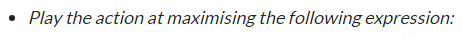  
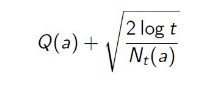

In [3]:
def UCB(models, N) :
    start_time = time.time()
    d = len(models) #模型數
    numbers_of_selections = [0] * d #計錄每個模型被選擇的次數
    sums_of_reward = [0] * d #計錄每個模型的總獎賞
    total_reward = 0 #總獎賞
    list_of_reward = []
    limit_of_cost = 8

    for n in range(0, N):
        ad = 0 #本次選擇的模型
        max_upper_bound = 0 #最大的上界
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) #把資料分成訓練用和測試用
        for i in range(0, d):

            #-------------------------------------------------------------------------
            #如果第i個模型訓練過，則執行此部分
            if (numbers_of_selections[i] > 0): 
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            #-------------------------------------------------------------------------
            
            #-------------------------------------------------------------------------
            #第i個模型沒有執行過，則運行此段
            else:
                upper_bound = 1e400 #設為一個極大值，讓此輪須先訓練此模型
            #-------------------------------------------------------------------------
            
            #選出上界最大的模型，做訓練
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        
        numbers_of_selections[ad] += 1
        t1 = time.time()
        models[ad].fit(X_train, y_train)
        t2 = time.time()
        y_pred = models[ad].predict(X_test)
        
        #cost 超過上限，則reward為0
        if(t2 - t1 > limit_of_cost) :
            reward = 0
        else :
            reward = 1 - np.sqrt(mean_squared_error(y_test, y_pred))
        
        sums_of_reward[ad] += reward
        total_reward += reward
        list_of_reward.append(total_reward)
        print(n, "\t", t2 - t1)
    end_time = time.time()
    print("Total reward : ", total_reward, "Cost : ", end_time - start_time)
    r = list_of_reward
    return list_of_reward


In [4]:
reward_of_UCB = UCB(models, N)

0 	 6.679693222045898
1 	 7.393664836883545
2 	 6.29582405090332
3 	 7.044846057891846
4 	 6.653058767318726
5 	 7.538202524185181
6 	 6.369173765182495
7 	 7.10014009475708
8 	 13.428159475326538
9 	 14.986169338226318
10 	 12.661185503005981
11 	 14.261603355407715
12 	 13.462690114974976
13 	 15.01626706123352
14 	 12.796078205108643
15 	 14.291091442108154
16 	 6.74416708946228
17 	 7.534131288528442
18 	 7.526769638061523
19 	 6.431681156158447
20 	 7.125463485717773
21 	 6.739309787750244
22 	 7.180082082748413
23 	 6.369601249694824
24 	 13.490566730499268
25 	 15.064595222473145
26 	 12.727524995803833
27 	 14.355642080307007
28 	 13.442199230194092
29 	 15.099308490753174
30 	 12.804627418518066
31 	 14.297651052474976
32 	 7.5354084968566895
33 	 6.399069309234619
34 	 6.734574794769287
35 	 7.572744607925415
36 	 7.172400951385498
37 	 7.084934711456299
38 	 6.681272983551025
39 	 6.369722127914429
40 	 6.7198004722595215
41 	 6.372117042541504
42 	 7.544489622116089
43 	 7.

* ### 第二步：  
##### 建立RCUCB演算法  

In [5]:
def cost_function(x) :
    return x
def penalty_function(x) :
    return 10 * x

In [6]:
def RCUCB(models, N) :
    start_time = time.time()
    d = len(models) #模型數
    ads_selected = [] #計錄每輪選擇的模型
    numbers_of_selections = [0] * d #計錄每個模型被選擇的次數
    sums_of_reward = [0] * d #計錄每個模型的總獎賞
    sums_of_cost = [0] * d #各個模型的每次執行的成本和
    sums_of_penalty = [0] * d #各個模型的每次執行的懲罰和
    limit_of_cost = 8 #成本的上限
    total_reward = 0 #總獎賞
    list_of_reward = []

    for n in range(0, N):
        ad = 0 #本次選擇的模型
        max_v = 0 #最大的上界
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        
        for i in range(0, d):

            #-------------------------------------------------------------------------
            #如果第i個模型訓練過，則執行此部分
            if (numbers_of_selections[i] > 0): 
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                average_cost = sums_of_cost[i] / numbers_of_selections[i]
                average_penalty = sums_of_penalty[i] / numbers_of_selections[i]
            #-------------------------------------------------------------------------
            
            #-------------------------------------------------------------------------
            #第i個模型沒有執行過，則運行此段
            else:
                average_reward = 1e400 #設為一個極大值，讓此輪須先訓練此模型
                average_cost = 0
                average_penalty = 0
            #-------------------------------------------------------------------------
            

            v = average_reward - average_cost - average_penalty

            if v > max_v:
                max_v = v
                ad = i
        
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        t1 = time.time()
        models[ad].fit(X_train, y_train)
        t2 = time.time()
        time_cost = t2 - t1
        y_pred = models[ad].predict(X_test)
        cost = cost_function(time_cost)
        penalty = penalty_function(time_cost)
        #cost 超過上限，則reward為0
        if(t2 - t1 > limit_of_cost) :
            reward = 0
        else :
            reward = 1 - np.sqrt(mean_squared_error(y_test, y_pred)) 
            penalty = 0
        sums_of_reward[ad] += reward
        sums_of_cost[ad] += cost
        sums_of_penalty[ad] += penalty
        total_reward += reward
        list_of_reward.append(total_reward)
        print(n, "\t", time_cost)
    
    end_time = time.time()
    print("Total reward : ", total_reward, "Cost : ", end_time - start_time)
    return list_of_reward


In [7]:
models = []
for n_estimators, max_features, min_samples_split, max_samples in l :
    models.append(RandomForestRegressor(n_estimators = n_estimators, max_features = max_features, min_samples_split = min_samples_split, max_samples = max_samples, random_state = 42))
    
len(models)

16

In [8]:
reward_of_RCUCB = RCUCB(models, N)

0 	 6.680354356765747
1 	 7.426737070083618
2 	 6.298266172409058
3 	 7.067456007003784
4 	 6.686274528503418
5 	 7.455530643463135
6 	 6.30690598487854
7 	 7.096259593963623
8 	 13.225005865097046
9 	 15.026687383651733
10 	 12.620474815368652
11 	 14.149891138076782
12 	 13.321009159088135
13 	 14.978017807006836
14 	 12.67661738395691
15 	 14.231171131134033
16 	 6.667530536651611
17 	 6.702123403549194
18 	 6.682514190673828
19 	 6.688817262649536
20 	 6.676532030105591
21 	 6.683365821838379
22 	 6.68157958984375
23 	 6.741338729858398
24 	 6.672520399093628
25 	 6.672573566436768
26 	 6.700777530670166
27 	 6.714426040649414
28 	 6.738255500793457
29 	 6.699092864990234
30 	 6.815160036087036
31 	 6.703412294387817
32 	 6.697715759277344
33 	 6.754419565200806
34 	 6.714590549468994
35 	 6.68622350692749
36 	 6.730186223983765
37 	 6.683945894241333
38 	 6.731862783432007
39 	 6.7111663818359375
40 	 6.7269206047058105
41 	 6.703350305557251
42 	 6.690459966659546
43 	 6.70637202

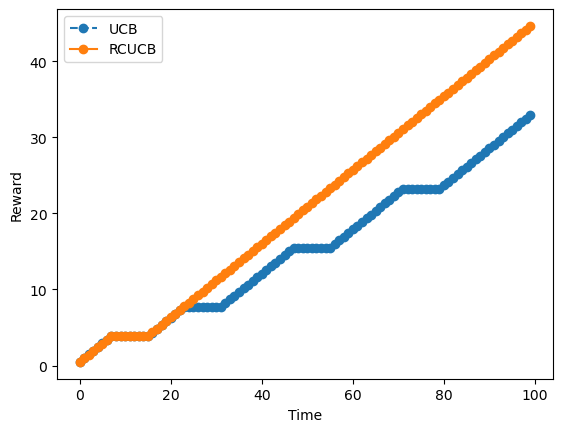

In [9]:
import matplotlib.pyplot as plt

plt.figure()
l1 = plt.plot(range(0, N), reward_of_UCB, label = "UCB")
plt.setp(l1, marker = 'o', linestyle = "--")
l2 = plt.plot(range(0, N), reward_of_RCUCB, label = "RCUCB")
plt.setp(l2, marker = 'o')
plt.xlabel("Time")
plt.ylabel("Reward")
plt.legend(loc='upper left')
plt.show()